In [1]:
%load_ext autoreload
%autoreload 2

import sklearn
from sklearn import datasets

In [2]:
iris = datasets.load_iris()

In [3]:
iris

{'DESCR': 'Iris Plants Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ==

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
print(iris.data.shape, iris.data.dtype)

(150, 4) float64


In [6]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [8]:
import numpy as np
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset

# All dataset is to train for simplicity
dataset = NumpyTupleDataset(iris.data.astype(np.float32), iris.target.astype(np.int32))
train = dataset

In [9]:
from chainer_chemistry.models.mlp import MLP
from chainer_chemistry.models.prediction.classifier import Classifier

out_dim = len(iris.target_names)
predictor = MLP(out_dim=out_dim, hidden_dim=16, n_layers=2)
classifier = Classifier(predictor)

In [24]:
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions as E


def fit(model, dataset, batchsize=16, epoch=10, out='results/tmp', device=-1):
    train_iter = iterators.SerialIterator(train, batchsize)
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    updater = training.StandardUpdater(
        train_iter, optimizer, device=device)
    trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

    #trainer.extend(E.Evaluator(val_iter, classifier,
    #                           device=device, converter=concat_mols))
    trainer.extend(E.LogReport())

    trainer.extend(E.PrintReport([
        'epoch', 'main/loss', 'main/accuracy', 'validation/main/loss',
        'validation/main/accuracy', 'elapsed_time']))
    trainer.run()

In [25]:
fit(classifier, train, batchsize=16, epoch=50)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.447513    0.91875                                                        0.0194008     
2           0.459575    0.875                                                          0.0904439     
3           0.432816    0.8875                                                         0.15855       
4           0.420468    0.923611                                                       0.213452      
5           0.42775     0.944444                                                       0.268492      
6           0.416628    0.93125                                                        0.325936      
7           0.412068    0.930556                                                       0.384639      
8           0.414339    0.923611                                                       0.43999       
9           0.398932    0.93125                                                     

## Saliency visualization

In [26]:
from chainer_saliency.calculator.gradient_calculator import GradientCalculator
from chainer_saliency.calculator.integrated_gradients_calculator import IntegratedGradientsCalculator
from chainer_saliency.link_hooks.variable_monitor_link_hook import VariableMonitorLinkHook


# 1. instantiation
gradient_calculator = GradientCalculator(classifier)
#gradient_calculator = IntegratedGradientsCalculator(classifier, steps=3,



In [60]:
M = 40

# --- VanillaGrad ---
# 2. compute
saliency_arrays_vanilla = gradient_calculator.compute_vanilla(train)
# 3. transform
saliency_vanilla = gradient_calculator.aggregate(
    saliency_arrays_vanilla, ch_axis=None, method='square')
# saliency_arrays (1, 28, 43, 64) -> M, minibatch, max_atom, ch_dim
print('saliency_arrays', saliency_arrays_vanilla.shape)
# saliency (28, 43) -> minibatch, max_atom
print('saliency', saliency_vanilla.shape)

saliency_arrays (1, 150, 4)
saliency (150, 4)


In [61]:
saliency_vanilla_mean = np.mean(saliency_vanilla, axis=0)

In [62]:
saliency_vanilla_mean

array([3.2040008e-04, 9.8176410e-05, 6.6706422e-04, 3.2811484e-04],
      dtype=float32)

In [63]:
saliency_vanilla_mean / np.sum(saliency_vanilla_mean)

array([0.22663046, 0.0694437 , 0.47183844, 0.23208739], dtype=float32)

In [64]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

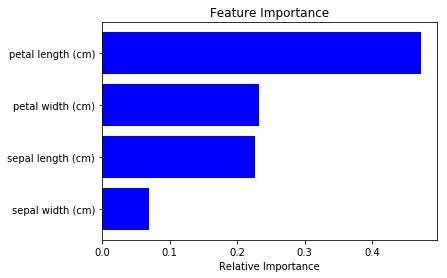

In [65]:
from chainer_saliency.visualizer.table_visualizer import TableVisualizer
from chainer_saliency.visualizer.common import normalize_scaler

visualizer = TableVisualizer()
visualizer.visualize(saliency_vanilla_mean, feature_names=iris.feature_names, num_visualize=-1,
                    scaler=normalize_scaler)

In [59]:
indices = np.argsort(saliency_vanilla_mean)

In [42]:
indices

array([1, 0, 3, 2])

In [43]:
a = ['a', 'b', 'c', 'd']
np.array(a)[indices]

array(['b', 'a', 'd', 'c'], dtype='<U1')

In [44]:
# a[indices]  # it is not possible to apply indices on list.

TypeError: only integer scalar arrays can be converted to a scalar index

## sklearn random forest feature importance

Ref:
 - https://qiita.com/TomokIshii/items/290adc16e2ca5032ca07
 - https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

In [45]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)

accu = accuracy_score(y_test, y_pred)
print('accuracy = {:>.4f}'.format(accu))

# Feature Importance
fti = clf_rf.feature_importances_   

print('Feature Importances:')
for i, feat in enumerate(iris['feature_names']):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

accuracy = 1.0000
Feature Importances:
	sepal length (cm)    : 0.026795
	sepal width (cm)     : 0.008660
	petal length (cm)    : 0.488153
	petal width (cm)     : 0.476392


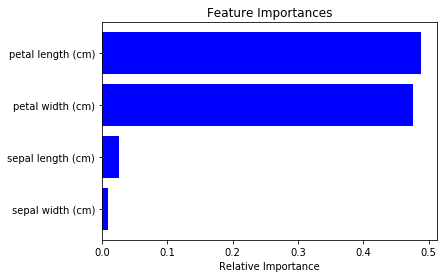

In [46]:
features = iris['feature_names']
importances = clf_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()